In [1]:
def cosine(a,b):
    return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b)+1e-12)

[-0.88584227 -1.70663376  0.81794885  0.85554548 -1.26723864 -0.17545075
 -0.24199691 -1.68151812  1.33487878 -0.98961237 -1.75551464  0.16493998
  1.95830504  1.63210439 -1.60583023 -0.9982324   0.24582147  1.62859825
  1.43580746 -1.47594052]
[-0.88584227 -1.70663376  0.81794885  0.85554548 -1.26723864 -0.17545075
 -0.24199691 -1.68151812  1.33487878 -0.98961237 -1.75551464  0.16493998
  1.95830504  1.63210439 -1.30291511 -0.9982324   0.24582147  1.62859825
  1.43580746 -1.47594052]
[-0.88584227 -1.70663376  0.81794885  0.85554548 -1.26723864 -0.17545075
 -0.24199691 -1.68151812  1.33487878 -0.98961237 -1.75551464  0.16493998
  1.95830504  1.63210439 -1.30291511 -0.9982324  -0.37708926  1.62859825
  1.43580746 -1.47594052]
[-0.88584227 -1.70663376  0.81794885  0.85554548 -1.26723864 -0.17545075
 -0.24199691 -1.68151812  1.33487878 -0.98961237 -1.75551464  0.16493998
  1.95830504  1.63210439 -1.30291511 -0.9982324  -0.37708926  1.62859825
  0.21790373 -1.47594052]
[-0.94292114 -1.7066

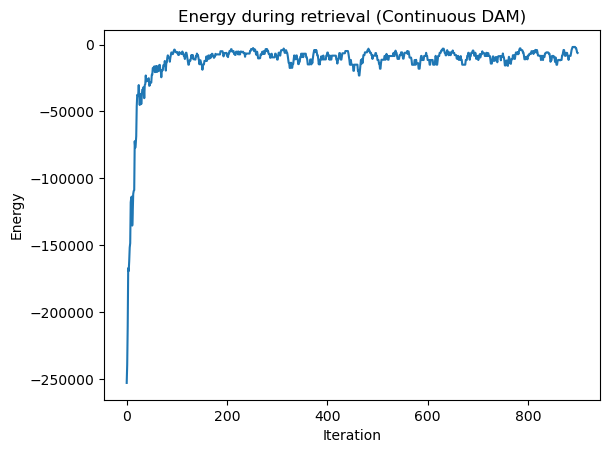

Cosine with true pattern: 0.4632394941455512
Cosine with all patterns:  [0.4632394941455512, -0.3266210598200234, 0.22596918979564468, 0.03314276864511638, 0.1001188784922754, 0.11649311308346753, 0.036329612029037936, 0.030260987291629425, 0.19336761131615457, 0.5627483784646234, 0.029898368706281483, -0.25584525706079103, -0.003266701183488897, 0.02302881353708365, -0.0034812484608795313]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from DAM import DenseAssociativeMemory

# simple random patterns for testing
K = 15
N = 20
"""
Track changes for different values for the relaxation paramaters

"""
patterns = np.random.choice([-1,1], size=(K,N))

dam = DenseAssociativeMemory(patterns, n=4, beta=2.0, alpha=0.5)

# pick one pattern and add gaussian noise
target = patterns[0].copy()
noisy = target + 0.5*np.random.randn(N)

retrieved, best, trace = dam.retrieve(noisy, steps=900)

plt.plot(trace)
plt.title("Energy during retrieval (Continuous DAM)")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.show()

print("Cosine with true pattern:", cosine(retrieved, target))
cosine_with_all = [cosine(retrieved, pattern) for pattern in patterns]
print("Cosine with all patterns: ", cosine_with_all)


K=1, correctly recalled: 1/1 with average recall accuracy of 0.7856211729779932
K=2, correctly recalled: 2/2 with average recall accuracy of 0.8302209470968561
K=3, correctly recalled: 3/3 with average recall accuracy of 0.8314958452722019
K=4, correctly recalled: 4/4 with average recall accuracy of 0.7853313206128052
K=5, correctly recalled: 5/5 with average recall accuracy of 0.834241493750674
K=6, correctly recalled: 6/6 with average recall accuracy of 0.7923749601122826
K=7, correctly recalled: 7/7 with average recall accuracy of 0.8251818866475793
K=8, correctly recalled: 8/8 with average recall accuracy of 0.7967730903412935
K=9, correctly recalled: 9/9 with average recall accuracy of 0.8033229830035393
K=10, correctly recalled: 10/10 with average recall accuracy of 0.8029619879430022
K=11, correctly recalled: 11/11 with average recall accuracy of 0.8096061267761464
K=12, correctly recalled: 12/12 with average recall accuracy of 0.7943134491586238
K=13, correctly recalled: 13/13 

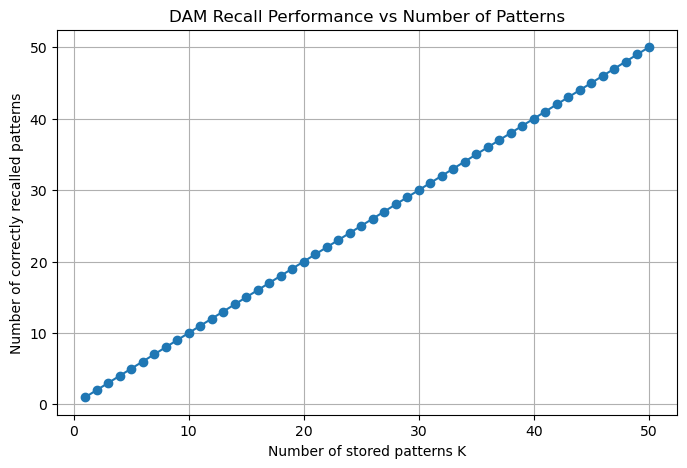

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from DAM import DenseAssociativeMemory
N = 100         
max_K = 50        
steps = 500       
noise_std = 0.5   
tolerance = 0.1   

K_values = []
recall_counts = []

for K in range(1, max_K + 1):
    patterns = np.random.choice([-1,1], size=(K,N))
    dam = DenseAssociativeMemory(patterns, n=1, beta=2, alpha=0.1)
    
    average_recall_simi = 0
    correct_recalls = 0
    for i in range(K):
        target = patterns[i].copy()
        noisy = target + noise_std*np.random.randn(N)
        retrieved, best, trace = dam.retrieve(noisy, steps=steps)

        if (1 - cosine(best, target)) <= tolerance:
            correct_recalls += 1
        average_recall_simi += cosine(retrieved, target)

    average_recall_simi /= K
    K_values.append(K)
    recall_counts.append(correct_recalls)
    print(f"K={K}, correctly recalled: {correct_recalls}/{K} with average recall accuracy of {average_recall_simi}")

plt.figure(figsize=(8,5))
plt.plot(K_values, recall_counts, marker='o')
plt.xlabel("Number of stored patterns K")
plt.ylabel("Number of correctly recalled patterns")
plt.title("DAM Recall Performance vs Number of Patterns")
plt.grid(True)
plt.show()


K=1, correctly recalled: 1/1 with average recall accuracy of 0.4599999999999954
K=2, correctly recalled: 2/2 with average recall accuracy of 0.4299999999999957
K=3, correctly recalled: 3/3 with average recall accuracy of 0.43333333333332896
K=4, correctly recalled: 4/4 with average recall accuracy of 0.47426305520244794
K=5, correctly recalled: 5/5 with average recall accuracy of 0.47624189138097706
K=6, correctly recalled: 6/6 with average recall accuracy of 0.5246614432093033
K=7, correctly recalled: 7/7 with average recall accuracy of 0.5068585519887286
K=8, correctly recalled: 7/8 with average recall accuracy of 0.4736001281907085
K=9, correctly recalled: 8/9 with average recall accuracy of 0.432834317469236
K=10, correctly recalled: 9/10 with average recall accuracy of 0.4318538963938292
K=11, correctly recalled: 10/11 with average recall accuracy of 0.4053866157742218
K=12, correctly recalled: 12/12 with average recall accuracy of 0.4994978273398694
K=13, correctly recalled: 13/1

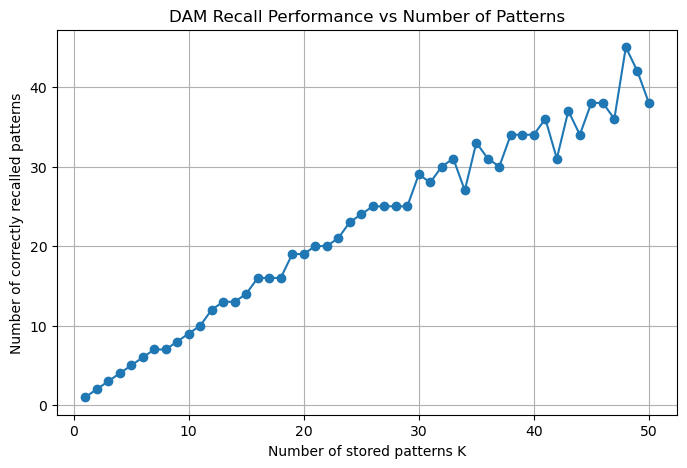

In [5]:
N = 100         
max_K = 50        
steps = 500       
noise_std = 0.5   
tolerance = 0.1   

K_values = []
recall_counts = []

for K in range(1, max_K + 1):
    patterns = np.random.choice([-1,1], size=(K,N))
    dam = DenseAssociativeMemory(patterns, n=4, beta=2, alpha=1)
    
    average_recall_simi = 0
    correct_recalls = 0
    for i in range(K):
        target = patterns[i].copy()
        noisy = target + noise_std*np.random.randn(N)
        retrieved, best, trace = dam.retrieve(noisy, steps=steps)

        if (1 - cosine(best, target)) <= tolerance:
            correct_recalls += 1
        average_recall_simi += cosine(retrieved, target)

    average_recall_simi /= K
    K_values.append(K)
    recall_counts.append(correct_recalls)
    print(f"K={K}, correctly recalled: {correct_recalls}/{K} with average recall accuracy of {average_recall_simi}")

plt.figure(figsize=(8,5))
plt.plot(K_values, recall_counts, marker='o')
plt.xlabel("Number of stored patterns K")
plt.ylabel("Number of correctly recalled patterns")
plt.title("DAM Recall Performance vs Number of Patterns")
plt.grid(True)
plt.show()


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from DAM import DenseAssociativeMemory
N = 20        
max_K = 50        
steps = 500       
noise_std = 0.5   
tolerance = 0.1   

K_values = []
recall_counts = []

for K in range(1, max_K + 1):
    patterns = np.random.choice([-1,1], size=(K,N))
    dam = DenseAssociativeMemory(patterns, n=4, beta=2, alpha=0.2)
    
    average_recall_simi = 0
    correct_recalls = 0
    for i in range(K):
        target = patterns[i].copy()
        noisy = target + noise_std*np.random.randn(N)
        retrieved, best, trace = dam.retrieve(noisy, steps=steps)

        if (1 - cosine(best, target)) <= tolerance:
            correct_recalls += 1
        average_recall_simi += cosine(retrieved, target)

    average_recall_simi /= K
    K_values.append(K)
    recall_counts.append(correct_recalls)
    print(f"K={K}, correctly recalled: {correct_recalls}/{K} with average recall accuracy of {average_recall_simi}")

plt.figure(figsize=(8,5))
plt.plot(K_values, recall_counts, marker='o')
plt.xlabel("Number of stored patterns K")
plt.ylabel("Number of correctly recalled patterns")
plt.title("DAM Recall Performance vs Number of Patterns")
plt.grid(True)
plt.show()


K=1, correctly recalled: 1/1 with average recall accuracy of 0.6791340983970289
K=2, correctly recalled: 2/2 with average recall accuracy of 0.6500984498246133
K=3, correctly recalled: 3/3 with average recall accuracy of 0.6736593879009405
K=4, correctly recalled: 4/4 with average recall accuracy of 0.681196240013328
K=5, correctly recalled: 4/5 with average recall accuracy of 0.5958080898568067
K=6, correctly recalled: 6/6 with average recall accuracy of 0.7186835041649302
K=7, correctly recalled: 7/7 with average recall accuracy of 0.6486836362730514
K=8, correctly recalled: 7/8 with average recall accuracy of 0.570871352310764
K=9, correctly recalled: 9/9 with average recall accuracy of 0.6824613970123381
K=10, correctly recalled: 7/10 with average recall accuracy of 0.654001909729599
K=11, correctly recalled: 8/11 with average recall accuracy of 0.5730639923434964
K=12, correctly recalled: 11/12 with average recall accuracy of 0.6054994577428917
K=13, correctly recalled: 11/13 with

KeyboardInterrupt: 

### How similarity with stored patterns evolves with iterations for $\alpha = 0.1$ (i.e. slowly updating the neuron's value)
Observation: The state first starts off with a simiarity of value $x$ with the target. It then starts decreasing with no limit apparently. The reason that the model was able to retrieve every single state for a small alpha value was that, even with noise, the initial noisy state was closest to the target pattern out of all the other patterns. And with small $\alpha$, we didn't deviate much from that state and we recover the pattern correctly. But if you use a higher value of alpha, the way that the vector is degrading is going to be apparent.

0.7177151352988885


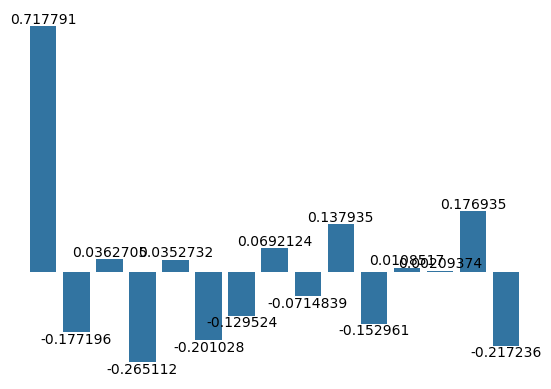

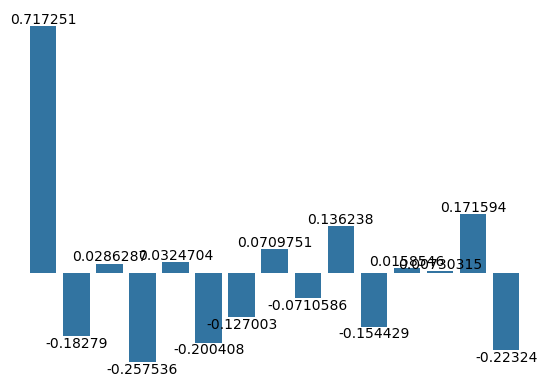

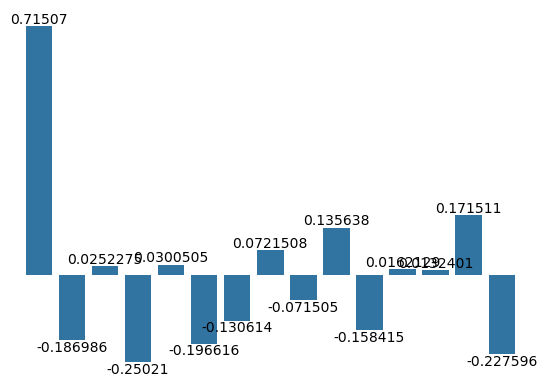

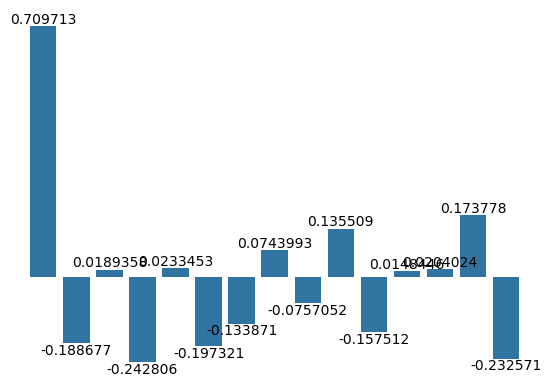

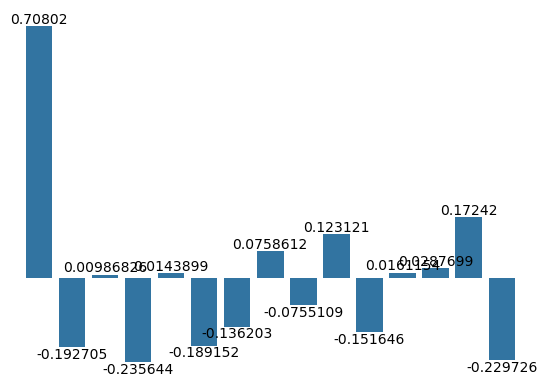

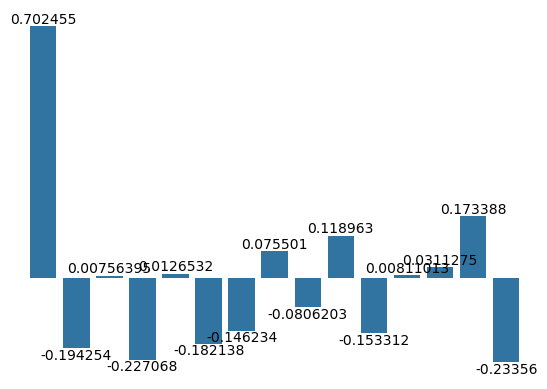

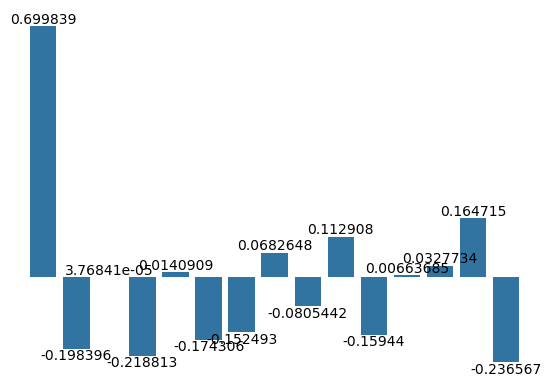

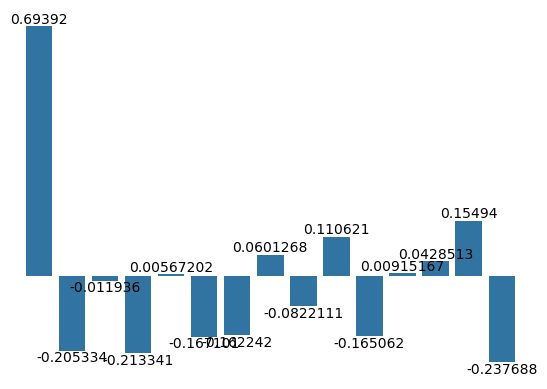

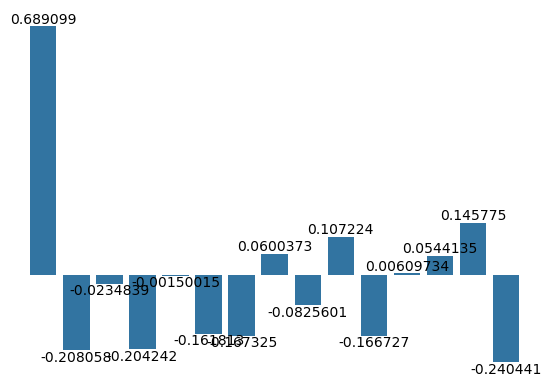

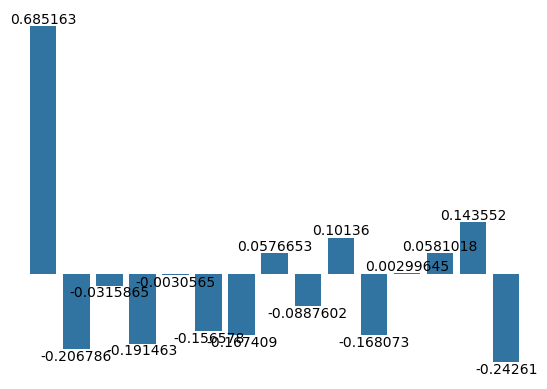

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from DAM import DenseAssociativeMemory

K = 15
N = 30

patterns = np.random.choice([-1,1], size=(K,N))

dam = DenseAssociativeMemory(patterns, n=4, beta=2.0, alpha=0.01)

# pick one pattern and add gaussian noise
target = patterns[0].copy()
noisy = target + 1*np.random.randn(N)
simi_noisy_target = np.dot(noisy, target) / (np.linalg.norm(noisy) * np.linalg.norm(target) + 1e-12)
print(simi_noisy_target)

retrieved, best, energy_trace, similarity_trace = dam.retrieve(noisy, steps=1000)

for i in range(0, 1000, 100):
    ax = sns.barplot(x=np.arange(len(similarity_trace[i])), y=similarity_trace[i])
    ax.bar_label(ax.containers[0])
    plt.axis('off')
    plt.show()

### How similarity with stored patterns evolves with iterations for $\alpha = 0.5$

0.7244308764598797


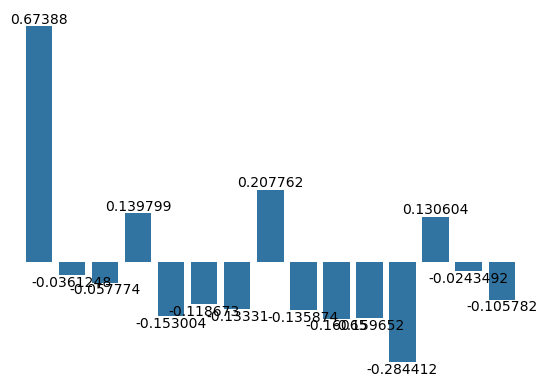

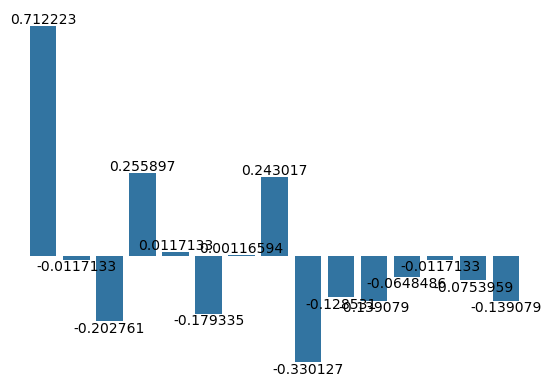

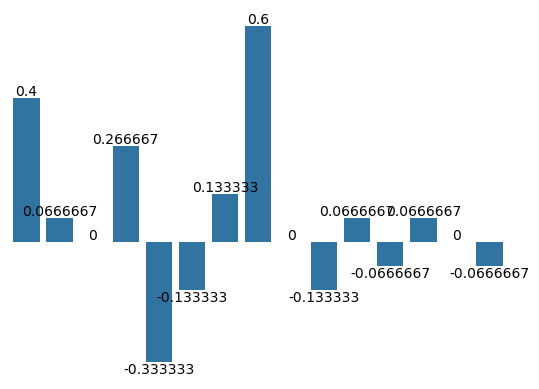

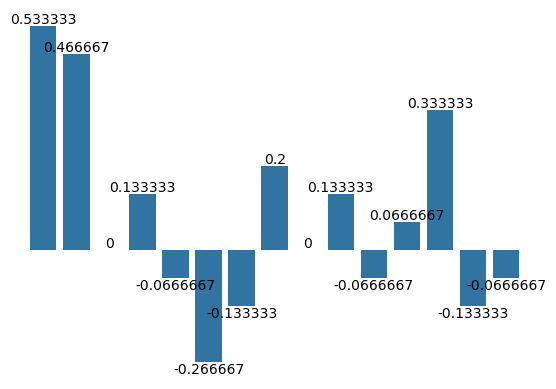

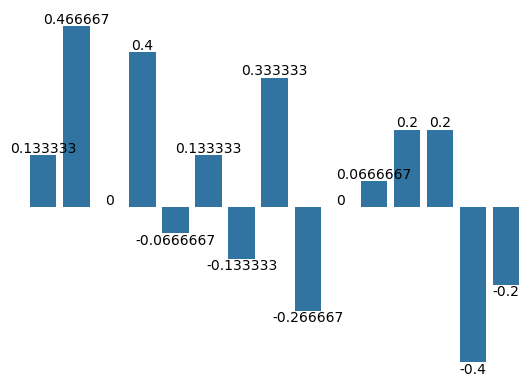

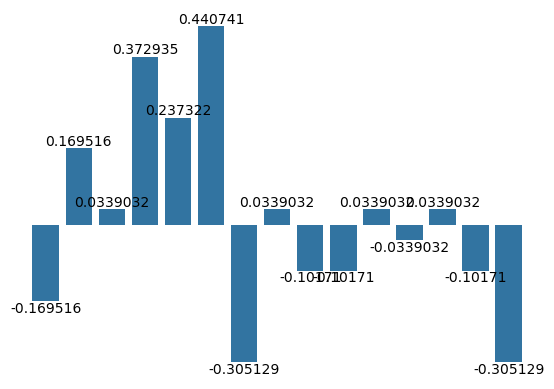

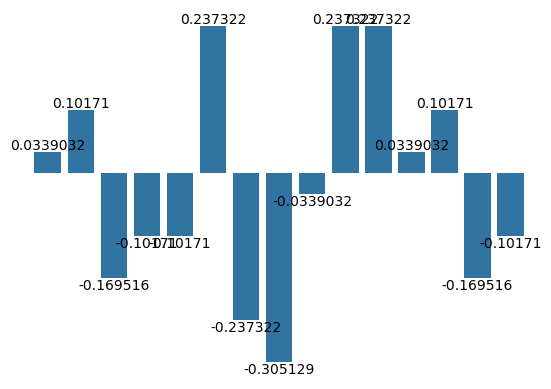

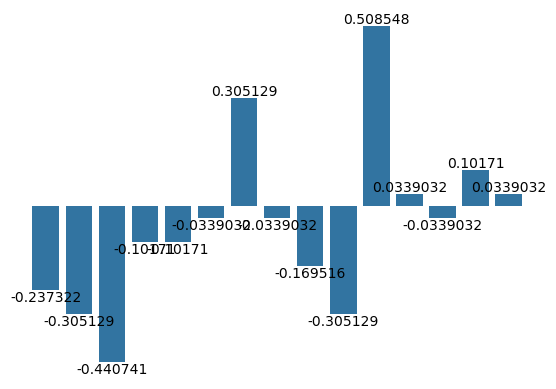

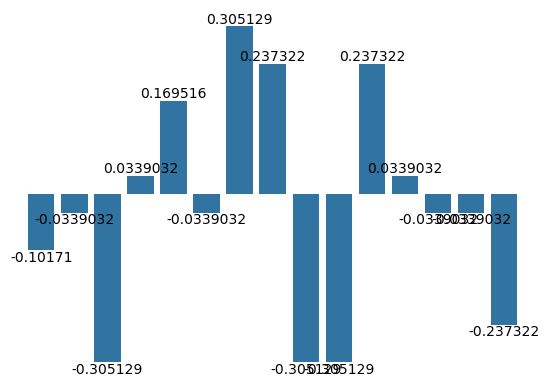

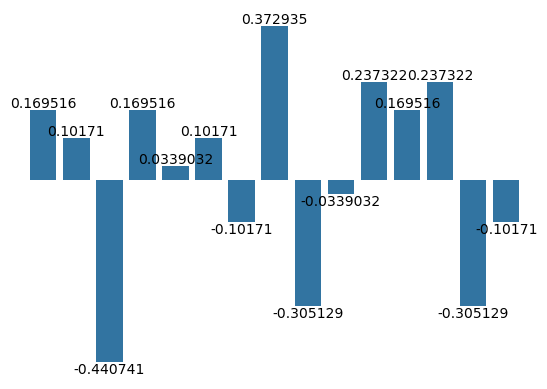

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from DAM import DenseAssociativeMemory

K = 15
N = 30

patterns = np.random.choice([-1,1], size=(K,N))

dam = DenseAssociativeMemory(patterns, n=4, beta=2.0, alpha=1)

# pick one pattern and add gaussian noise
target = patterns[0].copy()
noisy = target + 1*np.random.randn(N)
simi_noisy_target = np.dot(noisy, target) / (np.linalg.norm(noisy) * np.linalg.norm(target) + 1e-12)
print(simi_noisy_target)

retrieved, best, energy_trace, similarity_trace = dam.retrieve(noisy, steps=1000)

for i in range(0, 1000, 100):
    ax = sns.barplot(x=np.arange(len(similarity_trace[i])), y=similarity_trace[i])
    ax.bar_label(ax.containers[0])
    plt.axis('off')
    plt.show()

0.7442925804997735
1000


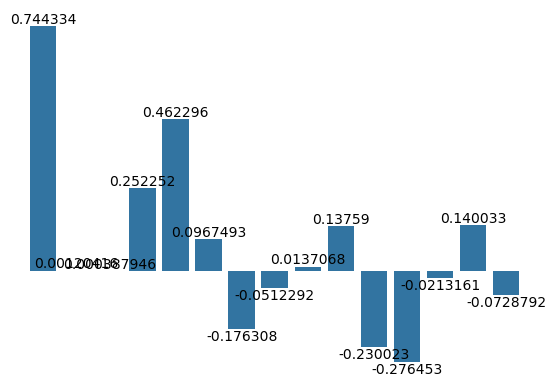

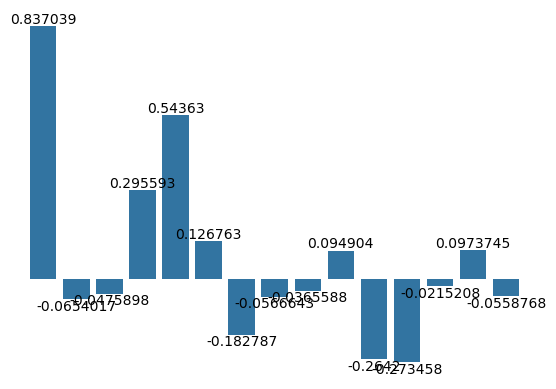

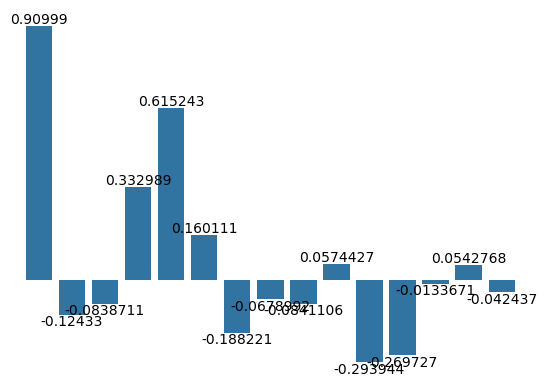

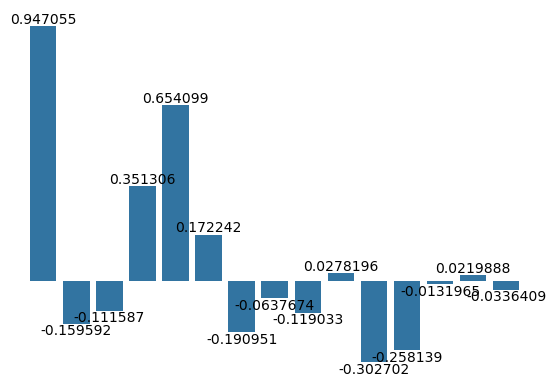

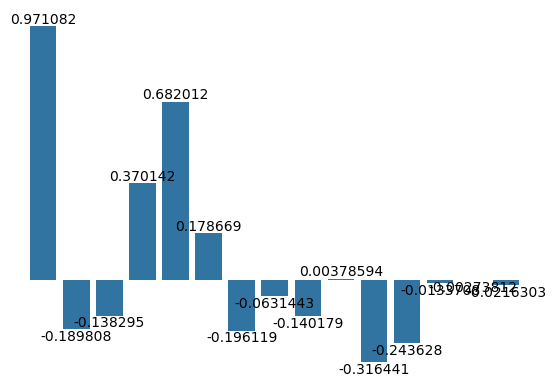

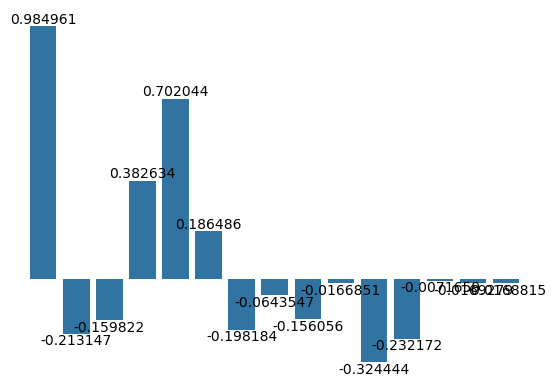

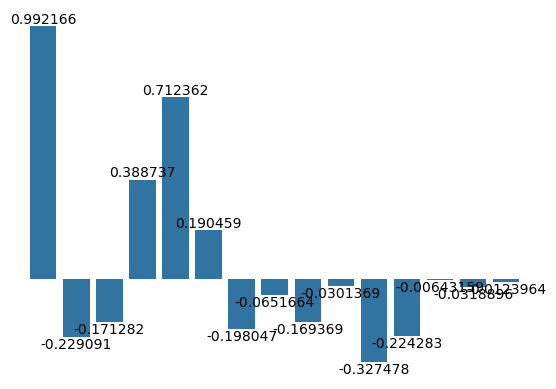

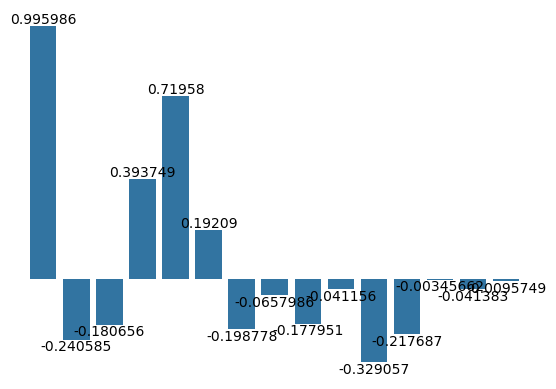

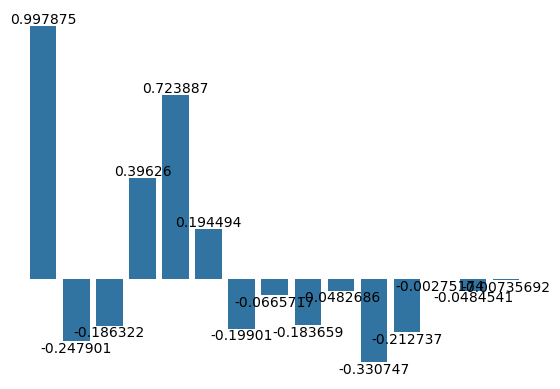

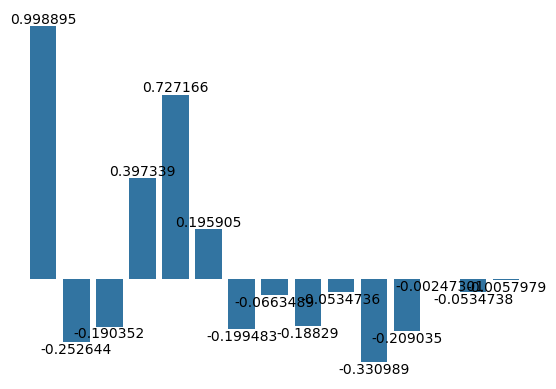

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from DAM import DenseAssociativeMemory

K = 15
N = 30

patterns = np.random.choice([-1,1], size=(K,N))

dam = DenseAssociativeMemory(patterns, n=4, beta=2.0, alpha=0.01)

# pick one pattern and add gaussian noise
target = patterns[0].copy()
noisy = target + 1*np.random.randn(N)
simi_noisy_target = np.dot(noisy, target) / (np.linalg.norm(noisy) * np.linalg.norm(target) + 1e-12)
print(simi_noisy_target)

retrieved, best, energy_trace, similarity_trace = dam.retrieve_differential(noisy, steps=10000)
print(len(similarity_trace))

for i in range(0, len(similarity_trace), 100):
    ax = sns.barplot(x=np.arange(len(similarity_trace[i])), y=similarity_trace[i])
    ax.bar_label(ax.containers[0])
    plt.axis('off')
    plt.show()

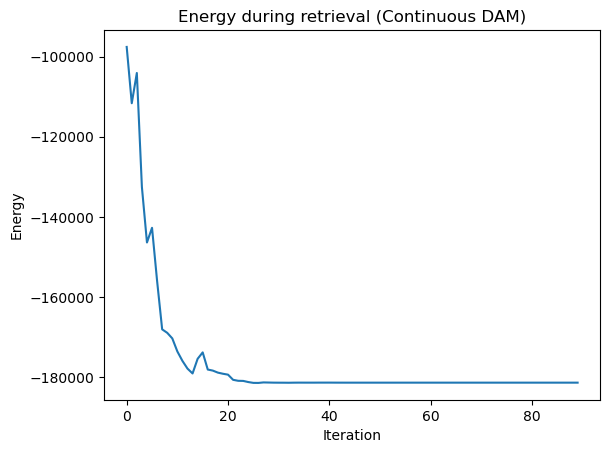

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from DAM import DenseAssociativeMemory

# simple random patterns for testing
K = 15
N = 20
"""
Track changes for different values for the relaxation paramaters

"""
patterns = np.random.choice([-1,1], size=(K,N))

dam = DenseAssociativeMemory(patterns, n=4, beta=2.0, alpha=0.5)

# pick one pattern and add gaussian noise
target = patterns[0].copy()
noisy = target + 0.5*np.random.randn(N)

retrieved, best, energy_trace, similarity_trace = dam.retrieve_differential(noisy, steps=900)

plt.plot(energy_trace)
plt.title("Energy during retrieval (Continuous DAM)")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.show()

